In [ ]:
import pandas as pd
import re
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
from statsmodels.stats.outliers_influence import variance_inflation_factor

from stats.reg import coefplot, prettify_coefs, compute_vif, main_effects, joint_effect, cond_effect, catvar

In [2]:
point_panel_in = "../../../../data/final/point_panel.parquet"
line_panel_in = "../../../../data/final/line_panel.parquet"
tract_panel_in = "../../../../data/final/tract_panel.parquet"

# Pipeline in

In [3]:
point_panel = pd.read_parquet(point_panel_in)
line_panel = pd.read_parquet(line_panel_in)
tract_panel = pd.read_parquet(tract_panel_in)

# Preprocess

In [4]:
# Since DNC does not occur during weekends, there is perfect multi-colinearity 
# between DNC and weekend ie. P(DNC=True | weekend=True) == 0
# The best way to resolve this is to remove weekend days from the dataset.
# They don't provide any information about treatment and only add unnecessary
# variance and increase our standard errors.
# Note: if we expand the treatment period in a robustness check we'll need to recover these dates.

assert point_panel[point_panel['weekend']==1]['DNC'].sum() == 0
assert line_panel[line_panel['weekend']==1]['DNC'].sum() == 0
assert tract_panel[tract_panel['weekend']==1]['DNC'].sum() == 0

point_panel_wkd = point_panel.query('weekend == 0')
line_panel_wkd = line_panel.query('weekend == 0')
tract_panel_wkd = tract_panel.query('weekend == 0')

# Validate Treatment Size

In [5]:
# Total observations
pd.crosstab(point_panel_wkd['UCMP'], point_panel_wkd['transit'])

transit,bike,train,uber
UCMP,,,
0,50169,8704,62152
1,2971,492,2548


In [6]:
# Unique units
plot_data = point_panel_wkd.drop_duplicates(['UCMP','transit','id'])
pd.crosstab(plot_data['UCMP'], plot_data['transit'])

transit,bike,train,uber
UCMP,,,
0,1503,136,1208
1,47,8,40


In [7]:
# Total observations
pd.crosstab(line_panel_wkd['UCMP'], line_panel_wkd['transit'])

transit,bus,train
UCMP,,
0,6400,256
1,1536,256


In [8]:
# Unique units
plot_data = line_panel_wkd.drop_duplicates(['UCMP','transit','id'])
pd.crosstab(plot_data['UCMP'], plot_data['transit'])

transit,bus,train
UCMP,,
0,100,4
1,24,4


In [9]:
# Total observations
pd.crosstab(tract_panel_wkd['UCMP'], tract_panel_wkd['transit'])

transit,bike,bus,train,uber
UCMP,,,,
0,26900,53504,6400,62152
1,2356,2752,876,2548


In [10]:
# Unique units
plot_data = tract_panel_wkd.drop_duplicates(['UCMP','transit','id'])
pd.crosstab(plot_data['UCMP'], plot_data['transit'])

transit,bike,bus,train,uber
UCMP,,,,
0,606,836,100,1208
1,37,43,14,40


# Modeling Scripts

In [ ]:
# # XXX: RUN ONCE!

if not globals().get('monkey_patched', False):
    OLSfit = sm.OLS.fit
    def fit(self, *args, **kwargs):
        """Monkey-patches OLS fit to report cleaner regression variable names."""
        # XXX: This doesn't seem to really help much.
        fitted = OLSfit(self, *args, **kwargs)
        # fitted.model.exog_names = cleaned_names  # Can't set this :(
        if hasattr(fitted.params, 'index'):
            fitted.params.index = prettify_coefs(fitted.params.index)
        if hasattr(fitted.model.data, 'cov_names'):
            fitted.model.data.cov_names = prettify_coefs(fitted.model.data.cov_names)
        return fitted
    sm.OLS.fit = fit

    RegressionResultsSummary = RegressionResults.summary
    def summary(self, *args, exclude_like=None, **kwargs):
        """Monkey-patches OLS summary to report cleaner regression variable names."""
        names = prettify_coefs(self.model.exog_names)
        s = RegressionResultsSummary(self, *args, xname=names, **kwargs)
        return s
    RegressionResults.summary = summary

monkey_patched = True

In [14]:
def model_did(df, transit_ref: str):
    transit = catvar(df, "transit", transit_ref)
    # formula = f"""np.log1p(rides) ~ 
    #             (UCMP * DNC) + 
    #             (UCMP * {transit}) + 
    #             (lat + long)**2 + I(lat**2) + I(long**2)"""
    formula = f"""np.log1p(rides) ~ 
                (UCMP * DNC * {transit}) + 
                (lat + long)**2 + I(lat**2) + I(long**2)"""
    did_model = sm.OLS.from_formula(formula, df).fit()
    return did_model

In [ ]:
def model_fe(df, transit_ref: str):
    model_data = df.assign(tid=df["transit"]+":"+df["id"])
    transit = catvar(model_data, "transit", transit_ref)
    formula = f"""np.log1p(rides) ~ 
                (UCMP * DNC * {transit}) +
                tid"""
    did_model = sm.OLS.from_formula(formula, model_data).fit()
    return did_model

# DiD

We estimate the difference-in-difference model as:

$$ \log{rides_{it}} = \beta_0 + \beta_1 \text{DNC}_t + \beta_2 \text{UC}_i + \beta_3 \text{DNC}_t \text{UC}_i + X_{it} + u_{it} $$

where $t$ is daily, $\text{DNC}_t=1$ if $t$ is one of the four official DNC days, and $\text{UC}_i=1$ if the station is inside the security perimeter and 0 otherwise, and $t$ spans the entire summer months of June, July, August to be able to test parallel pre-trends (note: Woldridge 13.2 only uses two time periods of weekly-aggregated data (maybe just for exposition?) and doesn't mention the parallel trends assumption).
We log-transform Y because the counts data span 6 orders of magnitude per station.

In [16]:
point_did = model_did(point_panel_wkd, "train")
print(point_did.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(rides)   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.265e+04
Date:                Sat, 09 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:10:36   Log-Likelihood:            -2.0577e+05
No. Observations:              127036   AIC:                         4.116e+05
Df Residuals:                  127019   BIC:                         4.117e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.06

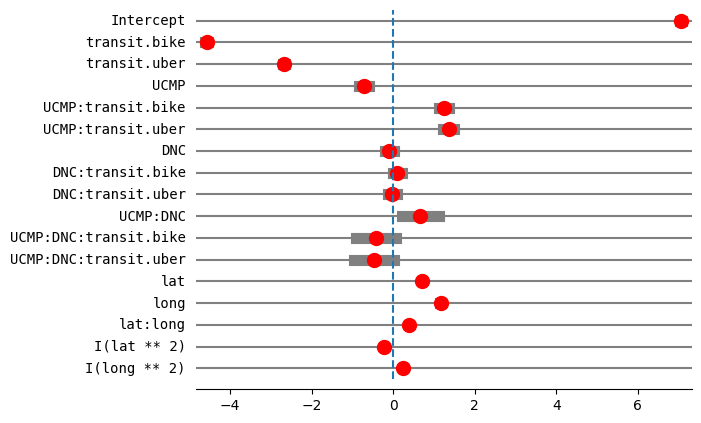

In [17]:
chart = coefplot(point_did)

In [18]:
line_did = model_did(line_panel_wkd, "train")
print(line_did.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(rides)   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     402.7
Date:                Sat, 09 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:10:37   Log-Likelihood:                -12454.
No. Observations:                8448   AIC:                         2.493e+04
Df Residuals:                    8435   BIC:                         2.503e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.5334 

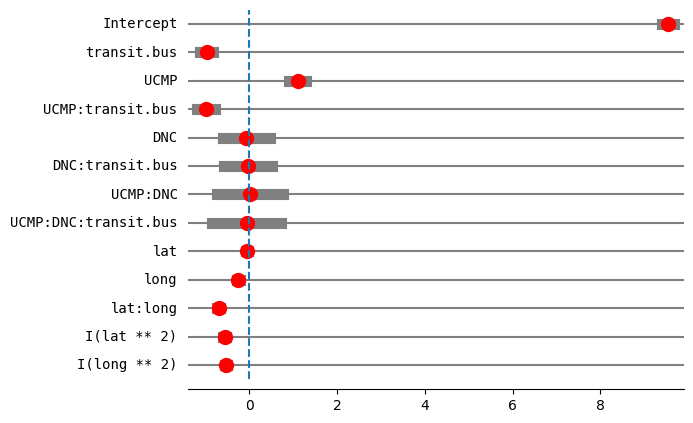

In [19]:
chart = coefplot(line_did)

In [20]:
tract_did = model_did(tract_panel_wkd, "train")
print(tract_did.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(rides)   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 1.860e+04
Date:                Sat, 09 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:10:38   Log-Likelihood:            -2.7233e+05
No. Observations:              157488   AIC:                         5.447e+05
Df Residuals:                  157467   BIC:                         5.449e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.39

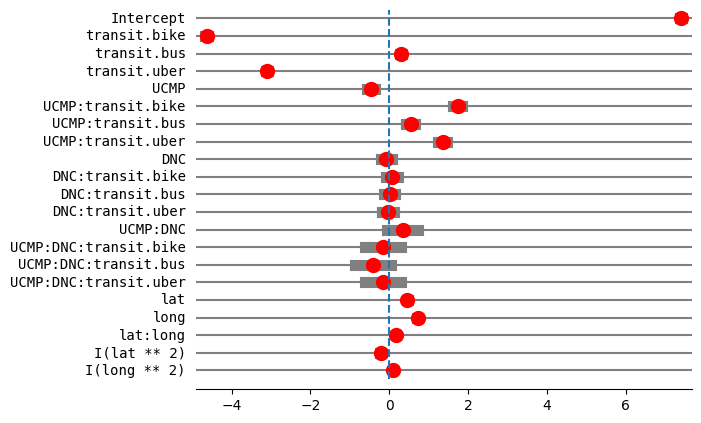

In [21]:
chart = coefplot(tract_did)

# Fixed Effects


$$ \log{rides_{it}} = \beta_0 + \beta_1 \text{DNC}_t + \beta_2 \text{UC}_i + \beta_3 \text{DNC}_t \text{UC}_i + X_{it} + u_{it} $$



We estimate:

$$
\log \text{rides}_{it} = \beta_0 + \beta_1 \text{DNC}_t + \beta_2 \text{UC}_i + \gamma_i +  u_{it}
$$

In [ ]:
# Takes ~3m to run. Maybe re-implement via manually time-demeaning first? 
# (would need to adjust dof). Or just wait.
point_fe = model_fe(point_panel_wkd, "train")
print(point_fe.summary())
# TODO: Need to interpret this and also decide if I believe it.

                            OLS Regression Results                            
Dep. Variable:        np.log1p(rides)   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1063.
Date:                Sat, 09 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:19:17   Log-Likelihood:                -58754.
No. Observations:              127036   AIC:                         1.234e+05
Df Residuals:                  124088   BIC:                         1.522e+05
Df Model:                        2947                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

# Next Steps

IDK I need to approach this with more planning. 

What do I actually want to do next?

I need to incorporate the other panel models? Or do I? Which are justified?
Which is the most justified at least? What would we actually feel comfortable reporting?
What are the threats, and what are the directions they bias the OLS?
Sometimes your bias makes your significant/unsignificnat effect stronger, right?

Make sure to do a slate of model validation for any model you want to report,

Need to do parallel trends check for DiD model.

Find or implement a robust way to compute conditional effects. eg. is DNC:UMCP
significant given transit=uber? Include correct addition of standard errors in this.

# Treatment Effects

In [ ]:
# I'm not sure if this is exactly what I want? Because I have a treatment
# set and a treatment period so I'm not sure how to handle that.
# from statsmodels.treatment.treatment_effects import TreatmentEffect
# def model_teff(df, treat_col, treat_formula, outcome_formula):
#     # treatment selection model
#     res_probit = sm.Probit.from_formula(treat_formula, df).fit()

#     # outcome model
#     mod = sm.OLS.from_formula(outcome_formula, df)

#     # treatment indicator variable
#     tind = np.asarray(df[treat_col])

#     teff = TreatmentEffect(mod, tind, results_select=res_probit)
#     return teff.ipw()

# treat_formula = 'UCMP ~ airport + (lat + long)**2 + I(lat**2) + I(long**2)'
# outcome_formula = 'np.log1p(rides) ~ UCMP * DNC + DNC * transit'
# model_teff(point_panel_did_weekly, 'UCMP', treat_formula, outcome_formula)